### 1. `query()`：告别繁琐的布尔索引

In [1]:
import pandas as pd

data = {
    'city': ['北京', '上海', '北京', '广州', '北京'],
    'amount': [500, 1200, 1500, 800, 2000],
    'use_coupon': [True, False, False, True, False]
}
df = pd.DataFrame(data)

# 传统写法（可读性差）
result_bad = df[(df['city'] == '北京') 
                & (df['amount'] > 1000) 
                & (df['use_coupon'] == False)]

# query() 写法（清晰明了）
target_city = '北京'
min_amount = 1000
result_good = df.query(
    "city == @target_city & amount > @min_amount & use_coupon == False"
    )
print(result_good)

  city  amount  use_coupon
2   北京    1500       False
4   北京    2000       False


### 2. `assign()`：优雅的链式特征工程

In [2]:
import pandas as pd

data = {
    'price': [10, 20, 30],
    'quantity': [3, 4, 5],
    'discount': [0.1, 0.2, 0.15]
}
df = pd.DataFrame(data)

# assian() 链式操作
df_processed = (
    df.assign(
        total_amount = df['price'] * df['quantity'],
        # 注意：可以直接引用在同一次 assign 中创建的列（需要使用 lambda）
        actual_payment = lambda x: x['total_amount'] * (1 - x['discount'])
    )
    .sort_values(by='actual_payment', ascending=False)
)
print(df_processed)

   price  quantity  discount  total_amount  actual_payment
2     30         5      0.15           150           127.5
1     20         4      0.20            80            64.0
0     10         3      0.10            30            27.0


### 3. `groupby().agg()`：终极聚合大法

In [3]:
import pandas as pd

df = pd.DataFrame({
    'user_id': ['u1', 'u2', 'u1', 'u3', 'u2'],
    'session_duration': [30, 45, 25, 60, 35],
    'order_amount': [100, 0, 200, 50, 300],
    'visit_date': pd.to_datetime(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-01', '2023-01-04'])
})

# 一次性完成多种聚合操作
user_report = df.groupby('user_id').agg(
    total_duration = ('session_duration', 'sum'),
    avg_order_amount = ('order_amount', 'mean'),
    unique_days_visited = ('visit_date', 'nunique'), # 统计独立访问天数
    last_visit = ('visit_date', 'max') # 最近访问日期
)
print(user_report)

         total_duration  avg_order_amount  unique_days_visited last_visit
user_id                                                                  
u1                   55             150.0                    2 2023-01-03
u2                   80             150.0                    2 2023-01-04
u3                   60              50.0                    1 2023-01-01


### 4. `np.select()`：向量化的 `if-elif-else`

In [4]:
import pandas as pd
import numpy as np

df = pd.DataFrame({
    'user_id': ['u1', 'u2', 'u3', 'u4', 'u5'],
    'total_spent': [500, 3500, 1500, 8000, 1200],
    'frequency': [10, 8, 3, 5, 1]
})

# 1. 定义条件列表（从最严格到最宽松）
conditions = [
    (df['total_spent'] >= 5000) & (df['frequency'] >= 10),
    (df['total_spent'] >= 3000),
    (df['total_spent'] >= 1000)
]

# 2. 定义对应的选择结果
choices = ['白金会员', '黄金会员', '白银会员']

# 3. 使用 np.select, default 是所有条件都不满足时的默认值
df['membership_level'] = np.select(conditions, choices, default='青铜会员')

print(df)

  user_id  total_spent  frequency membership_level
0      u1          500         10             青铜会员
1      u2         3500          8             黄金会员
2      u3         1500          3             白银会员
3      u4         8000          5             黄金会员
4      u5         1200          1             白银会员


### 5. `astype('category')`：节省一半内存的秘密

In [5]:
import pandas as pd
import numpy as np

# 模拟一个大型数据集
cities = ['北京', '上海', '广州', '深圳', '杭州']
data = {'city': np.random.choice(cities, size=10_000_000), 'metrics': np.random.randn(10_000_000)}
df = pd.DataFrame(data)

print(f'原始内存占用：{df.memory_usage(deep=True).sum() / 1024**2:.2f} MB')

# 转换为 category 类型
df['city'] = df['city'].astype('category')

print(f'转换后内存占用：{df.memory_usage(deep=True).sum() / 1024**2:.2f} MB')

原始内存占用：743.87 MB
转换后内存占用：85.83 MB


### 6. `pipe()`：构建可复用的数据管道

In [ ]:
import pandas as pd

# 1. 定义一个自定义的清洗函数
def clean_data(data_df):
    # 假设这个函数做了很多复杂操作
    data_df = data_df.dropna(subset=['email'])
    data_df.loc[:, 'age'] = data_df['age'].fillna(data_df['age'].median())
    data_df.loc[:, 'phone'] = data_df['phone'].str.replace(r'-', '', regex=False)

    return data_df

# 模拟数据
raw_df = pd.DataFrame({
    'email': ['smith@gmail.com', None, 'anna@gmail.com'],
    'age': [25, None, 30],
    'phone': ['123-456', '789-012', '345-678']
})

# 2. 使用 pipe() 将函数嵌入链式调用
cleaned_df = (
    raw_df
    .pipe(clean_data) # <--- 在这里使用 pipe
    .assign(domain = lambda x: x['email'].str.split('@').str[1])
)
print(cleaned_df)

             email   age   phone     domain
0  smith@gmail.com  25.0  123456  gmail.com
2   anna@gmail.com  30.0  345678  gmail.com


### 7. `melt()`：宽表转长表（数据规整）

In [10]:
import pandas as pd

df_wide = pd.DataFrame({
    'Product': ['A', 'B'],
    'Jan_Sales': [100, 120],
    'Feb_Sales': [110, 130],
    'Mar_Sales': [105, 115]
})

# 转换为长表
df_long = df_wide.melt(
    id_vars=['Product'], # 保持不变的 ID 列
    value_vars=['Jan_Sales', 'Feb_Sales', 'Mar_Sales'], # 需要被“融化”的列
    var_name='Month_Raw', # “变量”列的新名称（比如 Jan_Sales）
    value_name='Sales'    # "值"列的新名称（比如 100）
)

# （可选）进一步清理月份
df_long['Month'] = df_long['Month_Raw'].str.replace('_Sales', '')

print(df_long)

  Product  Month_Raw  Sales Month
0       A  Jan_Sales    100   Jan
1       B  Jan_Sales    120   Jan
2       A  Feb_Sales    110   Feb
3       B  Feb_Sales    130   Feb
4       A  Mar_Sales    105   Mar
5       B  Mar_Sales    115   Mar


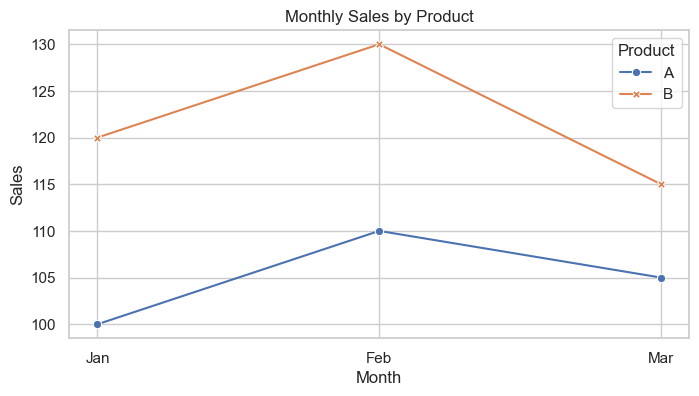

In [13]:
# 现在可以轻松地用 df_long 来绘制图表
import seaborn as sns
import matplotlib.pyplot as plt

# 把 Month 设置为有序类目，避免月份顺序混乱
month_order = ['Jan', 'Feb', 'Mar']
df_long['Month'] = pd.Categorical(df_long['Month'], categories=month_order, ordered=True)

sns.set_theme(style='whitegrid')
plt.figure(figsize=(8, 4))
sns.lineplot(data=df_long, x='Month', y='Sales', hue='Product',
             style='Product', markers=True, dashes=False, errorbar=None)
plt.title('Monthly Sales by Product')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

### 8. `.str.extract()`：向量化的正则表达式提取

In [14]:
import pandas as pd

df = pd.DataFrame({'user_agent': [
    'Mozilla/5.0 (iPhone; CPU iPhone OS 15_0 like Mac OS X)',
    'Mozilla/5.0 (Android 11; Mobile; rv:100.0) Gecko/100.0 Firefox/100.0',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64)'
]})

# 定义正则表达式
# 第一个组捕获（iPhone|Android|Windows NT [0-9.]+）
# 第二个组捕获（OS 15_0|Android 11|Windows NT 10.0）
# (这是一个简化的例子，真实UA regex会更复杂)
regex_pattern = r'\((.*?);' # 简单提取括号里的第一部分

df['device_info'] = df['user_agent'].str.extract(regex_pattern)

# 提取多个组，会返回多个列
regex_multi = r'(iPhone|Android) (\d+)' # 捕获（iPhone或Android）和（后面的数字）
df[['Device', 'Version']] = df['user_agent'].str.extract(regex_multi)

print(df)

                                          user_agent      device_info  \
0  Mozilla/5.0 (iPhone; CPU iPhone OS 15_0 like M...           iPhone   
1  Mozilla/5.0 (Android 11; Mobile; rv:100.0) Gec...       Android 11   
2          Mozilla/5.0 (Windows NT 10.0; Win64; x64)  Windows NT 10.0   

    Device Version  
0      NaN     NaN  
1  Android      11  
2      NaN     NaN  


### 9. `.resample()`：时间序列的降维打击

In [16]:
import pandas as pd
import numpy as np

rng = pd.date_range('2023-01-01 09:30', '2023-01-02 16:00', freq='1min')
df = pd.DataFrame({'price': np.random.normal(100, 2, len(rng))}, index=rng)

# 1. 确保索引是 DatetimeIndex（我们的例子已经是了）
# df.set_index('timestamp', inplace=True)

# 2. 按天（D）重采样，并使用 .agg()
# 'ohlc' 是一个内置的快捷方式，等同于 .agg({'price': ['first', 'max', 'min', 'last']})
df_daily_ohlc = df['price'].resample('D').ohlc()

# 你也可以自定义聚合
df_hourly_stats = df['price'].resample('h').agg(['mean', 'std', 'count'])

print(df_daily_ohlc.head())
print(df_hourly_stats.head())

                 open        high        low       close
2023-01-01  98.781789  105.923592  93.791510  102.188259
2023-01-02  98.265720  105.226659  94.488089  100.700821
                           mean       std  count
2023-01-01 09:00:00  100.559700  2.002007     30
2023-01-01 10:00:00  100.048741  2.098375     60
2023-01-01 11:00:00   99.532697  1.742763     60
2023-01-01 12:00:00   99.797910  1.839812     60
2023-01-01 13:00:00  100.110503  1.833178     60


### 10. `pd.merge_asof()`：最强时序匹配

In [ ]:
import pandas as pd

# 1. 报价数据（右表）
quotes = pd.DataFrame({
    'time': pd.to_datetime(['10:00:01.000', '10:00:01.500', '10:00:02.100', '10:00:03.000'], format='%H:%M:%S.%f'),
    'bid_price': [10.01, 10.02, 10.01, 10.03]
})

# 2. 交易数据（左表）
trades = pd.DataFrame({
    'time': pd.to_datetime(['10:00:01.600', '10:00:01.700', '10:00:03.500'], format='%H:%M:%S.%f'),
    'volume': [100, 50, 200]
})

# 重点：两个表必须按 ‘on’ 的键（这里是 time）排好序
quotes.sort_values(by='time', inplace=True)
trades.sort_values(by='time', inplace=True)

# 3. 执行 asof merge
# direction='backward'（默认）意味着在 'quotes' 中寻找 <= 'trades' 时间的最新一条
merged_df = pd.merge_asof(
    trades,
    quotes,
    on='time',
    direction='backward' # 'backward' (<=), 'forward' (>=), 'nearest'（最近）
)

print(merged_df)

                     time  volume  bid_price
0 1900-01-01 10:00:01.600     100      10.02
1 1900-01-01 10:00:01.700      50      10.02
2 1900-01-01 10:00:03.500     200      10.03
